![airbnb_nyc](airbnb_newyork.jpg)



# Exploring Airbnb Prices in New York City
#### Aman Jaiman, Andrew Mao, Adam Howard
---

## Introduction
---

This winter, we're planning to take a trip to New York City! Everyone knows the cost of living there is sky-high, so naturally, we wanted to see if there was a way to find bargains. One popular option: Airbnb!

Airbnb is a shared economy platform for people to offer their own housing for travellers. Since 2008, it has grown in popularity and has become ubiquitous in travelling options, becoming a large competitor in the hotel industry. Competing with hotels and other Airbnbs makes pricing challenging for sellers. There are many features that can factor into the price - its proximity to popular locations, amenities, size, etc.

In this tutorial, we are aiming to see if there are certain features that contribute to price more than others. We also want to see if we can find outliers for the Airbnbs (bargains or ripoffs). We hope that this exploration can be useful for travelers looking to find a place in New York City, or for homeowners to be able to price their property at a competitive price to make a profit.


## Data Collection
---
For this tutorial, we will be using 2019 [New York City Airbnb data](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data), published by dgomonov on Kaggle. This data includes information about the hosts, geographical data, and other potential predictors of price.

We'll be using Python 3 for this tutorial, along with the following libraries:
* [Numpy](https://docs.scipy.org/doc/numpy/user/) - for linear algebra
* [Pandas](https://pandas.pydata.org/pandas-docs/stable/) - for manipulating and preprocessing the data
* [Scikit-Learn](http://scikit-learn.org/stable/documentation.html) - for machine learning
* [Seaborn](https://seaborn.pydata.org/) - making pretty plots (uses matplotlib)!
* [Folium](https://github.com/python-visualization/folium) - 
* [Plotly](https://github.com/plotly/plotly.py) - 
* [Matplotlib](https://matplotlib.org/) - more pretty plots (also necessary for seaborn)!
* [StatsModels](https://www.statsmodels.org/stable/index.html)

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

#import folium # generating maps
#from folium.plugins import MarkerCluster # marker clusters for map
#from folium.plugins import MiniMap # minimap display for map
#from IPython.display import HTML, display # displaying maps in the notebook
import seaborn as sns; sns.set() # graphing data

Let's take a look at what the data looks like. Open the `.csv` file in the kaggle folder

In [4]:
main_df = pd.read_csv('nyc.csv')
main_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Each entry gives us information about the property.
* The `name` of the property is set by the host
* `host_id` and `host_name` are identification ids of the host for Airbnb
* There are five groups in `neighbourhood_group`, shown above
* The `neighbourhood` tells us which specific neighbourhood in the group the property belongs to
* `latitude` and `longitude` give us the coordinates of the location. We can use this with folium to map all the locations
* `room_type` indicates the type of room the property is
* `price` will be the attribute we will try to predict
* `minimum_nights` are the minimum number of nights the property has to be booked for
* `number_of_reviews`, `last_review`, and `reviews_per_month` give us information about the reviews of each property. Unfortunately, we don't have the actual reviews or rating
* `calculated_host_listings_count` and `availability_365` are additional features that tell us how many total properties the host has, and how long this property is available in a year

Let's examine some basic stats:

There are close to 50k entries, so we want to sample data for plotting. Data seems to missing for some fields, most noticeably those relating to the number of reviews.

In [5]:
print(main_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

Let's examine the categorical variables.

In [10]:
print("Neighbourhood Groups:", main_df['neighbourhood_group'].unique().tolist())
print("Room Types:", main_df['room_type'].unique().tolist())

Neighbourhood Groups: ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']
Room Types: ['Private room', 'Entire home/apt', 'Shared room']


We are going to be working with Airbnbs in the five boroughs in New York City. There are three types of rooms: shared rooms, private rooms, or the entire home or apartment. We can expect the rooms to have a significant impact on the price, as people would prefer to have an entire home to themselves rather than a shared room, so homeowners will likely charge more. We will explore this later.

How about price? Let's see what our typically Airbnb is priced at, as well as what the outliers look like.

In [51]:
print(main_df['price'].describe(percentiles=[.25, .50, .75, .95]))

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
95%        355.000000
max      10000.000000
Name: price, dtype: float64


We find that there are some very large outliers, so for visualization purposes, we winsorize (ignore) the top 5% of data, about $400.

## Data Exploration
---
Now that we have seen the data that we are working with, let's visualize our data in order to get a better understanding of it.

We'll start by looking at some geographical data: 
* what boroughs have the most rooms?
* what is the price distribution of rooms per borough?
* what is the frequency and price distribution of rooms per room type?


#### Neighbourhood Groups

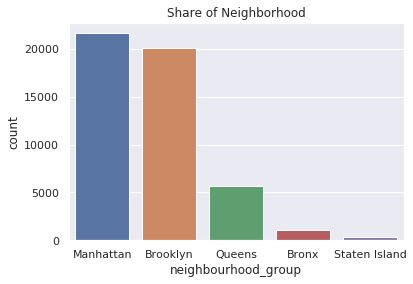

In [13]:
ax = sns.countplot('neighbourhood_group',data=main_df,order=main_df['neighbourhood_group'].value_counts().index)
ax.set_title('Share of Neighborhood')
plt.show()

Manhattan and Brooklyn have the highest number of listings, at around 20K each. This can be attributed to the fact that both of those neighbourhoods have more of the tourist attractions, so people would typically want to stay close to what they are seeing.

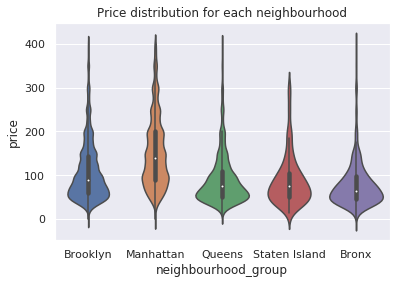

In [14]:
# ax = sns.scatterplot(x='neighbourhood_group', y='price', data=main_df, s=14)

#we can see from our statistical table that we have some extreme values, therefore we need to remove them for the sake of a better visualization

#creating a sub-dataframe with no extreme values / less than 500
winsorized_df=main_df[main_df.price < 400]
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(data=winsorized_df, x='neighbourhood_group', y='price')
viz_2.set_title('Price distribution for each neighbourhood')
plt.show()

Here we can see the distribution of prices of properties, based on which neighbourhood group they belong to. We can see that Manhattan sems to have more of the higher priced properties. Bronx, Staten Island, and Queens have much more reasonable prices compared to Brooklyn and Manhattan. All distributions have positive skew.

#### Room Type
Now that we've looked at the locations for the Airbnbs, let's explore the room types and how the price distribution changes.

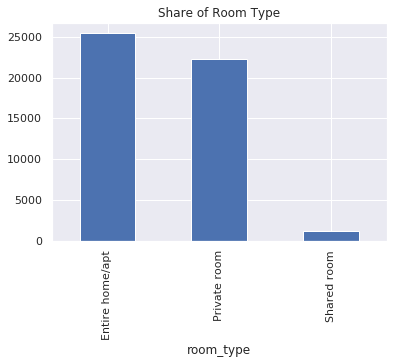

In [15]:
main_df.groupby('room_type').size().plot.bar()
plt.title("Share of Room Type")
plt.show()

We also see that entire homes and private rooms are the most common, which may be because the demand for shared rooms is typically lower.

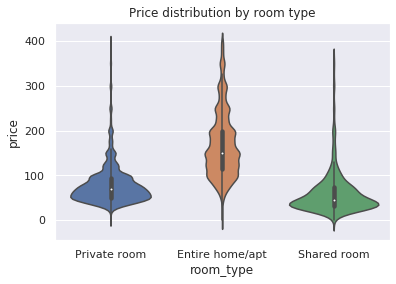

In [16]:
winsorized_df=main_df[main_df.price < 400]
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(data=winsorized_df, x='room_type', y='price')
viz_2.set_title('Price distribution by room type')
plt.show()

As expected, shared rooms have the lowest mean price, while entire homes have the highest. All room types seem to have a similar spread, however private rooms and shared rooms seemd to be more centered around their mean. There is more disparity of price with entire homes. 

Now let's see how the prices look on a map of New York City, so we can really visualize our data. First, We'll use folium to create a map centered around New York City. Because of issues with rendering the full dataset, we will randomly assign a value to each data point (between 0 and 1), and plot it on the map if the random value is less than .02, giving each data point a 2% random chance of being plotted.

Let's create a color scale for the markers that will be shown on the map. If we want 5 increments in our color scale, we'll split the prices into 5 even chunks and assign a color for each chunk.

In [17]:
prices = sorted(main_df['price'].unique().tolist())
partition_length = len(prices)//5 # we want 5 increments for our color scale
current = 0
for i in range(5):
    print(prices[current:current+partition_length][-1])
    current += partition_length

144
278
430
805
7703


In [18]:
# Assigning colors to the partitions
def get_color(price):
    if price <= 144:
        return 'darkblue'
    elif price <= 278:
        return 'lightblue'
    elif price <= 430:
        return 'lightred'
    elif price <= 805:
        return 'orange'
    else:
        return 'red'

In [19]:
m = folium.Map(location=[40.71455, -74.00712], zoom_start=13) # Creating a folium map

#mc = MarkerCluster()
import random
for i,row in main_df.sample(1000).iterrows():
#     if random.random() < .015:
    name = row['name']
    neighbourhood_group = row['neighbourhood_group']
    neighborhood = row['neighbourhood']
    lat = row['latitude']
    long = row['longitude']
    room_type = row['room_type']
    price = row['price']
    min_nights = row['minimum_nights']
    c = get_color(price)

    folium.CircleMarker(location=[lat, long], 
                        color=c, 
                        radius=2,
                        popup=(str(name)+": $"+str(price))).add_to(m)

    #mc.add_child(folium.Marker(location=[lat, long], icon=folium.Icon(color=c), popup=(str(name)+": $"+str(price))))
minimap = MiniMap()
m.add_child(minimap)
display(m)

NameError: name 'folium' is not defined

In [57]:
%%capture
# Geographic plot using Plotly
# Uncomment following line if plotly module not found
# !pip install plotly
import plotly.graph_objects as go

sample_df = winsorized_df.sample(1000)

# mapbox_access_token = open(".mapbox_token").read()
mapbox_access_token = "pk.eyJ1IjoibWFvc2VmIiwiYSI6ImNrMTNzYXY5dDBjcHIzbW51d2J1ZjJweHoifQ.CA3fec_PEoQHxf9jr7yGaA"

fig = go.Figure(go.Scattermapbox(
        lon = sample_df['longitude'],
        lat = sample_df['latitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=5,
            color = sample_df['price'],
            colorscale="RdBu",
            reversescale=True,
            colorbar=dict(
                title="Price ($)"
            ),
        ),
#         color_continuous_scale="IceFire",
#         text=['Montreal'],
    ))

fig.update_layout(
    title="Airbnb prices in New York City",
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=40.7,
            lon=-74
        ),
        pitch=0,
        zoom=9
    )
)

fig.show()

*Due to display issues when rendering to HTML, here is a screenshot of the output from the above code:*
![nyc_price_map](mapbox.png "Airbnb Prices in NYC")

We see there is definitely clustering of higher prices in downtown Manhattan. There are also noticeable clusters in Upper Brooklyn and Upper Manhattan. Location could provide a good signal of price.

Let's examine the text of the reviews, and plot the most common words.

In [58]:
#### Popularity (Reviews per month)
#### NLP on Name

We look at a correlation plot among the numerical variables. We don't see any strong correlations between meaningful variables, except number_of_reviews vs reviews_per_month




In [59]:
main_df.corr().style.background_gradient(cmap='coolwarm')
# plt.show()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1,0.58829,-0.00312529,0.0909085,0.0106187,-0.0132245,-0.31976,0.291828,0.133272,0.0854676
host_id,0.58829,1,0.0202242,0.127055,0.0153091,-0.0173643,-0.140106,0.296417,0.15495,0.203492
latitude,-0.00312529,0.0202242,1,0.0847884,0.0339387,0.0248693,-0.0153888,-0.0101416,0.0195174,-0.0109835
longitude,0.0909085,0.127055,0.0847884,1,-0.150019,-0.0627471,0.0590943,0.145948,-0.114713,0.0827307
price,0.0106187,0.0153091,0.0339387,-0.150019,1,0.0427993,-0.0479542,-0.0306083,0.0574717,0.0818288
minimum_nights,-0.0132245,-0.0173643,0.0248693,-0.0627471,0.0427993,1,-0.0801161,-0.121702,0.12796,0.144303
number_of_reviews,-0.31976,-0.140106,-0.0153888,0.0590943,-0.0479542,-0.0801161,1,0.549868,-0.0723761,0.172028
reviews_per_month,0.291828,0.296417,-0.0101416,0.145948,-0.0306083,-0.121702,0.549868,1,-0.00942116,0.185791
calculated_host_listings_count,0.133272,0.15495,0.0195174,-0.114713,0.0574717,0.12796,-0.0723761,-0.00942116,1,0.225701
availability_365,0.0854676,0.203492,-0.0109835,0.0827307,0.0818288,0.144303,0.172028,0.185791,0.225701,1


## Predicting Price

The problem is of regressing price.

Let's try a multiple linear regression on the features. We drop the features (name, id, host name, and last review). We transform the categorical variables (neighbourhood_group, neighbourhood, room_type) into labels using Scikit-Learn's label transformer. 

We use Ordinary Least Squares (OLS) Regression. We hold out 20% of the data for testing. 

In [60]:
'''Machine Learning'''
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor


# Preparing the main_df 
main_df.drop(['name','id','host_name','last_review'],axis=1,inplace=True)
main_df['reviews_per_month']=main_df['reviews_per_month'].replace(np.nan, 0)

'''Encode labels with value between 0 and n_classes-1.'''
le = preprocessing.LabelEncoder() # Fit label encoder
le.fit(main_df['neighbourhood_group'])
main_df['neighbourhood_group']=le.transform(main_df['neighbourhood_group']) # Transform labels to normalized encoding.

le = preprocessing.LabelEncoder()
le.fit(main_df['neighbourhood'])
main_df['neighbourhood']=le.transform(main_df['neighbourhood'])

le = preprocessing.LabelEncoder()
le.fit(main_df['room_type'])
main_df['room_type']=le.transform(main_df['room_type'])

main_df.sort_values(by='price',ascending=True,inplace=True)

main_df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
25796,86327101,1,13,40.68258,-73.91284,1,0,1,95,4.35,6,222
25634,15787004,1,28,40.69467,-73.92433,1,0,2,16,0.71,5,0
25433,131697576,0,62,40.83296,-73.88668,1,0,2,55,2.56,4,127
25753,1641537,1,91,40.72462,-73.94072,1,0,2,12,0.53,2,0
23161,8993084,1,13,40.69023,-73.95428,1,0,4,1,0.05,4,28


In [61]:
'''Train LRM'''
lm = LinearRegression()

X = main_df[['neighbourhood_group','neighbourhood','latitude','longitude','room_type','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']]
y = main_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

For evaluation, we calculate Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and the coefficient of determination (R^2). 

MAE is the average of the absolute errors. 
MSE is the average of the squared errors. This penalizes larger errors by more. Taking the square root to get RMSE returns to our original units.

R^2 is the proportion of the variance in the dependent variable that is predictable from the independent variable.

From Scikit's documentation for R^2:

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

[Here's a more thorough explanation of evaluation metrics for regression.](https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4)

We use MAE, because we believe price outliers exist and don't want them to impact the error.
According to MAE, on average, our model is off by 72$. This is better than 1 standard deviation of guessing the mean (240), but realistically not that great.

In [62]:
'''Get Predictions & Print Metrics'''
predicts = lm.predict(X_test)

print("""
        Mean Absolute Error: {}
        Root Mean Squared Error: {}
        R2 Score: {}
     """.format(
        mean_absolute_error(y_test,predicts),
        np.sqrt(metrics.mean_squared_error(y_test, predicts)),
        r2_score(y_test,predicts),
        ))


        Mean Absolute Error: 74.59991200070456
        Root Mean Squared Error: 226.57236982815087
        R2 Score: 0.09665551242432535
     


We plot the regressor price predictions against the actual ones. This is to visually check if our regression estimates look good, as well as test if the assumptions of a linear relationship are satisfied. The assumptions are explained in detail [here.](https://www.statisticssolutions.com/assumptions-of-linear-regression/) 

Some core assumptions:
* error terms (residuals) are normally distributed around the regression line, and homoscedastic (spread doesn't grow or shrink).
* no multicollinearity - this is when a feature is itself linearly dependent on other features.

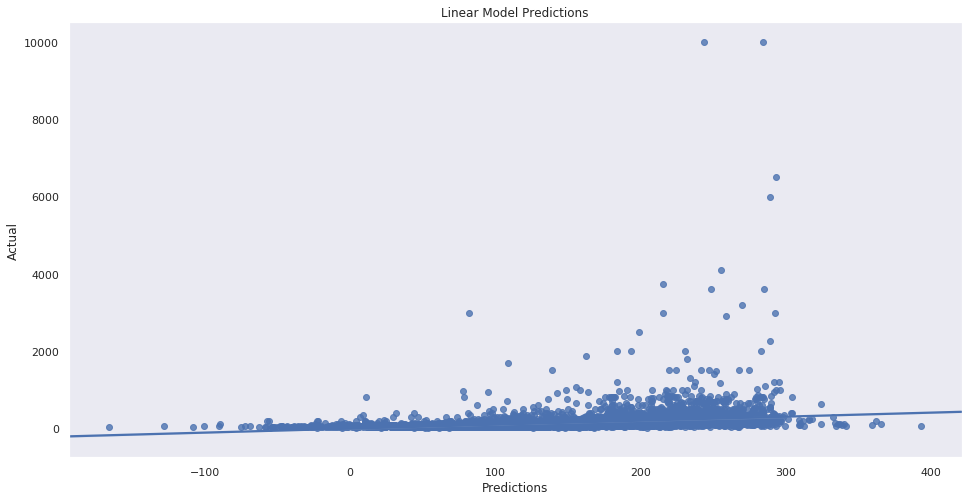

In [63]:
plt.figure(figsize=(16,8))
sns.regplot(predicts,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Model Predictions")
plt.grid(False)
plt.show()

We notice some large outliers in the positive direction. These represent listings that were much more expensive than expected. Perhaps this is an indication that they're a ripoff! Or there are more features that account for their price, such as room quality and amenities. 

This plot shows some problems: we notice our regressor is relatively conservative in predicting price (it doesn't go above 400), when there are listings in the thousands. We also notice it predicts negative prices for some listings, which is nonsensical. Unfortunately, the residuals don't seem to be evenly distributed around the regression line - this may indicate an issue with the model assumptions.


### Finding a Better Model
It seems as though there is a significant relationship between Airbnb price and and a variety of the features included in the dataset. However, considering the number of features in the present model, it is likely that we could find a more parsimonious model and improve our $R^2$ value. Unfortunately, SKLearn makes it difficult to analyze the significance of each of the predictors in a model. Instead, we can temporarily make use of Python's StatsModels library. This library in particular has some very powerful statistical tools including robust model summary information.

### Diagnostic Plots
Below are a few methods to generate diagnostic plots which can be used to check the assumptions for linearity.

* Plot of residual size against the fitted (predicted) value. We expect an even (homoscedastic), Gaussian distribution around y=0.
* Plot of residuals against the order the data was presented. If we see trends, then that indicates a serious problem.
* Histogram of residual sizes.

In [64]:
# Residuals vs. Fitted
def r_v_fit(m):
    ax = sns.residplot(m.fittedvalues, m.resid)
    plt.title("Residuals vs. Fitted")
    plt.ylabel("Residuals")
    plt.xlabel("Fitted Values")
    plt.show()
    
# Residuals vs. Order
def r_v_order(m):
    ax = plt.scatter(m.resid.index, m.resid)
    plt.title("Residuals vs. Order")
    plt.ylabel("Residuals")
    plt.xlabel("Order")
    plt.show()

# Histogram
def r_hist(m, binwidth):
    resid = m.resid
    plt.hist(m.resid, bins=np.arange(min(resid), max(resid) + binwidth, binwidth))
    plt.title("Histogram of Residuals")
    plt.show()

In [65]:
# Get separate dataframe for statsmodels analysis
sm_df = pd.read_csv('nyc.csv')

# Split data for training and testing
sm_df['logprice'] = np.log(1 + sm_df['price'])
train_data, test_data = train_test_split(sm_df, test_size=0.2)

P-Value:	1.8006884367200522e-17
R_Squared:	0.11798224182996442
R_Squared Adj:	0.1176132798691506


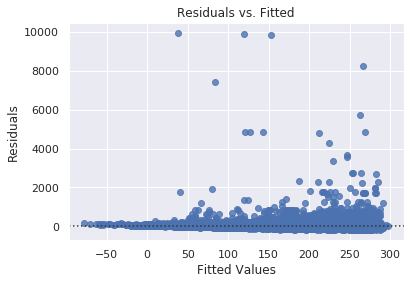

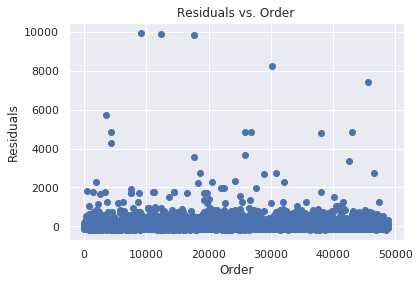

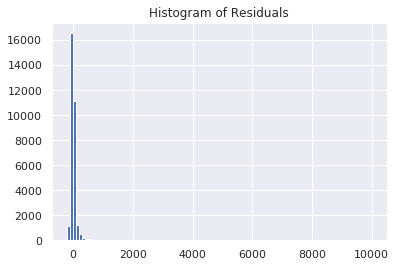

In [66]:
import statsmodels.formula.api as smf

# Create the model
model = smf.ols(
    'price ~ neighbourhood_group + latitude + longitude \
     + room_type + minimum_nights + number_of_reviews + reviews_per_month \
     + calculated_host_listings_count + availability_365',
    data=train_data).fit()

print("P-Value:\t{}".format(model.pvalues[0]))
print("R_Squared:\t{}".format(model.rsquared))
print("R_Squared Adj:\t{}".format(model.rsquared_adj))

# Diagnostic Plots for model
r_v_fit(model)
r_v_order(model)
r_hist(model, 100)

The above plots show a few issues with the current model. The residuals vs. fitted plot shows mostly positive residuals and a number of outliers. It also appears as though the plot has a cone shape, and therefore does not meet the equal spread condition for linear regression. Residuals vs. Order also shows a number of outliers and, like the vs. fitted plot, takes on mostly positive values. Lastly, the histogram of residuals is very skewed. This is likely due to the outliers as seen above. Also, the R-Squared value of the model (listed above the residual plots) is very low. 

Because of the skew in distribution of residuals/number of outliers, it may be useful to attempt a log transformation on the response (price). Let's try the new model out to see how it compares:

P-Value:	1.0826817734661715e-128
R_Squared:	0.5130876908707718
R_Squared Adj:	0.5128840077604754


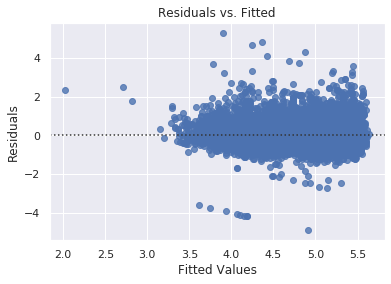

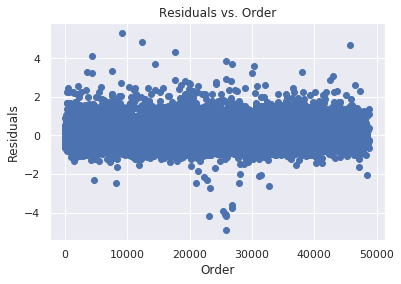

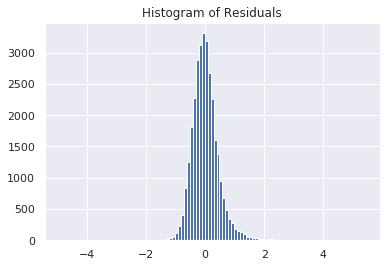

In [67]:
# Fitting a new model with a log-transformed price
log_model = smf.ols(
    'logprice ~ neighbourhood_group + latitude + longitude \
     + room_type + minimum_nights + number_of_reviews + reviews_per_month \
     + calculated_host_listings_count + availability_365',
    data=train_data).fit()

print("P-Value:\t{}".format(log_model.pvalues[0]))
print("R_Squared:\t{}".format(log_model.rsquared))
print("R_Squared Adj:\t{}".format(log_model.rsquared_adj))

# Diagnostic Plots for new, transformed model
r_v_fit(log_model)
r_v_order(log_model)
r_hist(log_model, 0.1)

Although there are still some outliers, this model immediately appears to be improved! All three diagnostic plots meet the assumptions necessary for using linear regression. There is still a slight cone shape to the residuals vs. fitted plot, but it looks much better. Residuals vs. order has better spread around the x-axis, which indicates independence of the data. Lastly, the histogram of residuals has a much more normal distribution than the original model. The R-Squared value is significantly higher than that of the original model, so this new model is much better for explaining price.

With this new nonlinear relationship, our interpretation of the model coefficients also changes. if we have a coefficient m, then an increase of X by 1 corresponds to an increase of log(Y) by m; this is equivalent to saying Y increases by a factor of e^m. 

### Reducing the Model
Now that we have a better model, it may be worth examining to see if any predictors may be removed from the model. The Statsmodels library has great summary statistics, so we can look at the p-value of each of the predictors to see how significant they are:

In [68]:
print(model.pvalues)

Intercept                               1.800688e-17
neighbourhood_group[T.Brooklyn]         4.251948e-02
neighbourhood_group[T.Manhattan]        2.298320e-05
neighbourhood_group[T.Queens]           4.204273e-01
neighbourhood_group[T.Staten Island]    1.325462e-18
room_type[T.Private room]               0.000000e+00
room_type[T.Shared room]                1.986989e-77
latitude                                2.263745e-07
longitude                               1.952355e-37
minimum_nights                          3.438375e-03
number_of_reviews                       1.388211e-13
reviews_per_month                       5.630876e-01
calculated_host_listings_count          1.813091e-02
availability_365                        8.810706e-88
dtype: float64


With a significance level of $\alpha=0.05$, we can see from the above output that only two of the predictors, Queens Borough and Reviews Per Month, are not significant predictors of price. Through backwards elimination we can remove these predictors one-by-one to see if our model improves. First we can start by eliminating reviews per month because it has the higher p-value.

In [69]:
log_model_1 = smf.ols(
    'logprice ~ neighbourhood_group + latitude + longitude \
     + room_type + minimum_nights + reviews_per_month \
     + calculated_host_listings_count + availability_365',
    data=train_data).fit()

print("P-Value:\t{}".format(log_model_1.pvalues[0]))
print("R_Squared:\t{}".format(log_model_1.rsquared))
print("R_Squared Adj:\t{}".format(log_model_1.rsquared_adj))

P-Value:	2.957016119131831e-125
R_Squared:	0.5121585158154411
R_Squared Adj:	0.5119701479085548


Because both $R^2$ and $R^2_{adj}$ decreased with the removal of Reviews per Month, we should keep the original log-transformed model and not continue to eliminate predictors. Therefore, we can settle on the following model:

$\widehat{price}=b_0 + b_1*n\_brooklyn + b_2*n\_manhattan + b_3*n\_queens + b_4*n\_staten + b_5*latitude + b_6*longitude + b_7*room\_private + b_8*room\_shared + b_9*minimum\_nights + b_{10}*reviews\_per\_month + b_{11}*listings\_count + b_{12}*availability$

We print the coefficients of the model:

In [70]:
model.params

Intercept                              -27084.057118
neighbourhood_group[T.Brooklyn]           -17.756057
neighbourhood_group[T.Manhattan]           33.544538
neighbourhood_group[T.Queens]               6.786568
neighbourhood_group[T.Staten Island]     -144.329882
room_type[T.Private room]                 -98.485986
room_type[T.Shared room]                 -134.381678
latitude                                 -162.436102
longitude                                -458.002497
minimum_nights                             -0.171048
number_of_reviews                          -0.192138
reviews_per_month                           0.434810
calculated_host_listings_count             -0.097930
availability_365                            0.170246
dtype: float64

The most sensitive coefficients are longitude, latitude, neighbourhood_group[T.Staten Island], and room_type[T.Shared room]. Coincidentally, they are all negatively correlated with price, which intuitively makes sense. The features most positively correlated with price are neighbourhood_group[T.Manhattan] and neighbourhood_group[T.Queens].


## Summary

We perform exploratory data analysis, examining listings across boroughs, room types, and location. We perform ordinary least squares regression on price, and find that there is some predictive power, however the assumptions of linearity aren't followed, indicating a nonlinear relationship. We perform a log-linear regression on price, and find the assumptions are satisfied, in addition to predictive power improving dramatically. We analyze the predictive power of each individual feature.

Things to do:

* Interpret the model, and what features have the most explanatory power
* Try a more complex model (Gradient Boosted Regressor)
* Try adding text as a feature (BoW,TF-IDF)
* Individually examine regressor outliers, both high and low. Can we find ripoffs or bargains?
* Normalize the data.

And there you have it! For cheap Airbnbs, look to the northeast, shared rooms, or Staten Island. Happy Airbnb hunting!